# Import neccessary libraries

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

# Create City and Fitness classes 

In [2]:
class City: # to create and handle cities
    def __init__(self,x,y): self.x,self.y=x,y
    def distance(self,city):
        xdis,ydis=abs(self.x-city.x),abs(self.y-city.y)
        return np.sqrt((xdis**2)+(ydis**2))
    def __repr__(self): return "("+str(self.x)+","+str(self.y)+")" #to output cities as coordinates
    def get(self): return [self.x,self.y] 

In [3]:
class Fitness:
    def __init__(self,route):
        self.route=route
        self.distance,self.fitness=0,0.0
    def routeDistance(self):
        if self.distance==0:
            pathDistance=0
            for i in range(len(self.route)):
                fromCity=self.route[i]
                toCity=None
                if i+1<len(self.route): toCity=self.route[i+1]
                else: toCity=self.route[0] # start and end at the same place
                pathDistance+=fromCity.distance(toCity)
            self.distance=pathDistance
        return self.distance
    def routeFitness(self): # inverse of the route distance
        if self.fitness==0: self.fitness=1/float(self.routeDistance())
        return self.fitness

# Create initial population

In [4]:
def createRoute(cityList): return random.sample(cityList,len(cityList)) # To create an individual
def initialPopulation(popSize, cityList): # List of routes
    population=[]
    for i in range(popSize): population.append(createRoute(cityList))
    return population

# Create the genetic algorithm

In [5]:
def rankRoutes(population): # Using Fitness class to rank each individual in the population
    fitnessResults={}
    for i in range(len(population)): fitnessResults[i]=Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(),key=operator.itemgetter(1),reverse=True)
    # returns an ordered list with the route IDs and each associated fitness score

In [6]:
# fitness-weighted probability of being selected.
def selection(popRanked,eliteSize): # used to make the list of parent routes
    selectionResults=[]
    #calculating relative fitness weight for each individual
    df=pd.DataFrame(np.array(popRanked),columns=["Index","Fitness"])
    df['cum_sum']=df.Fitness.cumsum()
    df['cum_perc']=100*df.cum_sum/df.Fitness.sum()
    # introduced elitism to hold on to best routes
    for i in range(eliteSize): selectionResults.append(popRanked[i][0]) 
    # comparing randomly drawn number to the weights to select mating pool
    for _ in range(len(popRanked)-eliteSize):
        pick=100*random.random()
        for i in range(len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults # returns a list of route IDs which are used to create the mating pool
def matingPool(population,selectionResults): #extracting the selected individuals from the population
    matingpool=[]
    for i in range(len(selectionResults)):
        index=selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [7]:
def breed(parent1,parent2): #crossover function for two parents to create one child
# breeding function used ordered crossover. we randomly select a subset of the first parent and then 
# fill the remainder of the route with the genes from the second parent.
    child=childP1=childP2=[]
    geneA,geneB=int(random.random()*len(parent1)),int(random.random()*len(parent1))
    startGene,endGene=min(geneA,geneB),max(geneA,geneB)
    for i in range(startGene,endGene): childP1.append(parent1[i])
    childP2=[item for item in parent2 if item not in childP1]
    return childP1+childP2
def breedPopulation(matingpool, eliteSize): #function to run crossover over full mating pool
    # used to create offspring population
    children=[]
    length=len(matingpool)-eliteSize
    pool=random.sample(matingpool,len(matingpool))
    # used elitism to retain the best routes from the current population
    for i in range(eliteSize): children.append(matingpool[i])
    # used the breed function to fill out the rest of the next generation
    for i in range(length):
        child=breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [8]:
def mutate(individual,mutationRate): #function to mutate a single route
# swap mutation is used. Here, two cities will swap places in a route according to the probability 
    for swapped in range(len(individual)):
        if(random.random()<mutationRate):
            swapWith=int(random.random()*len(individual))
            city1=individual[swapped]
            city2=individual[swapWith]
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual
def mutatePopulation(population,mutationRate): #function to run mutation over entire population
    mutatedPop=[]
    for ind in range(len(population)):
        mutatedInd=mutate(population[ind],mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [9]:
def nextGeneration(currentGen,eliteSize,mutationRate):
    popRanked=rankRoutes(currentGen) # ranking the routes in the current generation
    selectionResults=selection(popRanked,eliteSize) # determining potential parents
    matingpool=matingPool(currentGen,selectionResults) 
    children=breedPopulation(matingpool,eliteSize)
    nextGeneration=mutatePopulation(children,mutationRate)
    return nextGeneration

In [10]:
def geneticAlgorithm(population,popSize,eliteSize,mutationRate,generations):
    pop = initialPopulation(popSize,population)
    Initial_distance=1/rankRoutes(pop)[0][1]
    for i in range(generations): pop = nextGeneration(pop, eliteSize, mutationRate)
    Final_distance=1/rankRoutes(pop)[0][1]
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute,Initial_distance,Final_distance

In [11]:
def plotRoute(path,dis,r): # function to plot the salesman route
    x,y=[],[]
    for i in path:
        k=i.get()
        x.append(k[0])
        y.append(k[1])
    xf,yf=x[0],y[0]
    x.append(xf)
    y.append(yf)
    if r==1: plt.plot(x,y,color='g',linestyle='-',linewidth=1,marker='.',markerfacecolor='b',markersize=10)
    else: plt.scatter(x,y)
    plt.ylim(1,max(x)+20,10)
    plt.xlim(1,max(y)+20,10)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('TSP using genetic algorithm')
    if r==1:
        t="Distance: "+str(int(dis))+"kms"
        plt.text(5,5,t,style='italic')
    plt.show()

# Running the genetic algorithm

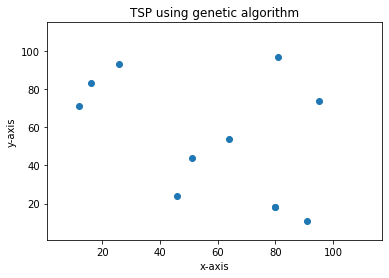

Initial route: (80,18) (51,44) (12,71) (26,93) (64,54) (95,74) (16,83) (46,24) (81,97) (91,11)
Initial route distance: 441.2757398196769 kms


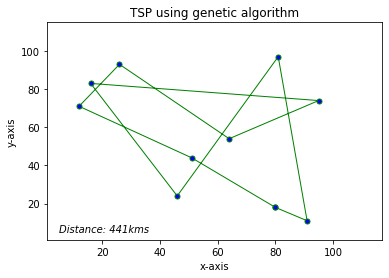

Best route: (12,71) (16,83) (26,93) (81,97) (95,74) (91,11) (80,18) (46,24) (51,44) (64,54)
Best route distance: 311.27801229924665 kms


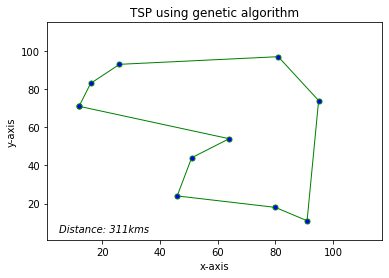

In [13]:
cityList=[]
for _ in range(10): cityList.append(City(x=int(random.random()*100),y=int(random.random()*100)))
R,ids,fds=geneticAlgorithm(population=cityList,popSize=40,eliteSize=10,mutationRate=0.01,generations=200)
plotRoute(cityList,ids,0)
print("Initial route:",*cityList)
print("Initial route distance:",ids,"kms")
plotRoute(cityList,ids,1)
print("Best route:",*R)
print("Best route distance:",fds,"kms")
plotRoute(R,fds,1)

# Plotting the improvement

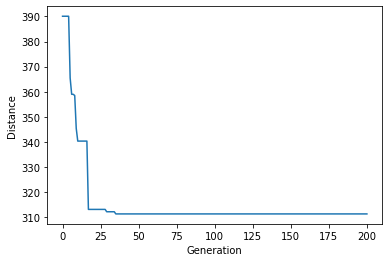

In [14]:
def geneticAlgorithmPlot(population,popSize,eliteSize,mutationRate,generations): #Seperate GA
    pop=initialPopulation(popSize,population)
    progress=[]
    progress.append(1/rankRoutes(pop)[0][1])
    for i in range(generations):
        pop=nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1/rankRoutes(pop)[0][1])
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
#to see how distance has improved in each generation
geneticAlgorithmPlot(population=cityList,popSize=40,eliteSize=10,mutationRate=0.01,generations=200)